# Overview of Methods

For each ward:

1. Use the shape file to extract the coordinates for the ward
2. Calculate a bounding box around ward. 
3. Get lat/lng of centers for each image in grid.
4. Write to /data/ward_image_centers.csv.

For each ward:

1. Read in the centers for each image.
2. Adjust the centers down.
3. Extract two images of size 400x425 from each adjusted center. One plain image and one with ward ovelayed in pure black.
4. Write each image to the directory /images/ward_k/ij_with_ward.png where k is the ward number and ij are the row and column positions, respectively, of the image in the grid of images from the specific ward (e.g. top left = 00).
5. Use the image with the ward overlayed to isolate the pixels that are outside of the ward. Set those pixels to black in the image without the ward in order to isolate the section of the image that contains the ward.
6. Remove the Google watermarks (i.e. bottom 25 pixels).
7. Write the edited image to the directory /images/ward_k/edited/ij.png

# Libraries Used

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import pandas as pd
import os
import ast

# Constants

### Conversion of lat/lng to pixels

In order to sample without overlap from the grid of images within the ward, we need to obtain the length of the sampled images in the y- and the x-direction.

In [4]:
## Radius of squares in grid, figured out by mixture of observation and calculation
Y_RAD = 0.00385
X_RAD = 0.0043
N_WARDS = 130

### Adjustment to crop out watermarks

Although we need images of dimension 400x400, we are sampling images of size 400x425 (more pixels in the y-direction) and cropping the bottom 25px in order to remove the Google watermarks - resulting in a 400x400 image. However, to do this, we need to shift the center of our sampled images slighly lower, as we are removing pixels from only the bottom of the image, even though there are $\approx 12.5$ pixels at the top of the image that are also being added. Thus, we need to shift the center down "12.5 pixels". Converting this to lat/lng values, we get that:
$200$px $\approx 0.00385^{\circ}$. So it follows that $12.5$px $\approx 0.00385^{\circ}/16$

<img src="../images_for_demo/Grid_img_without_adjustment.PNG" width="300">
<img src="../images_for_demo/Grid_img_with_adjustment.PNG" width="300">

In [5]:
DELTA_Y = Y_RAD/16  # adjustment to crop out watermarks

In [6]:
# get the Google Static Maps API key
with open("../google_api_key.txt", "r") as file:
    KEY = file.readline()

# Get Centers for Images in each Ward

Extract the unadjusted image centers for each image in the grid for each ward.

In [4]:
# Opening JSON file of ward shapes
def get_all_ward_shapes(file_name):
    f = open(file_name,) 
    shape_dict = json.load(f)                     # Returns JSON object as a dictionary 
    f.close()
    return shape_dict

In [5]:
## Extracting coordinates for first ward
def get_ward_shape(shape_dict, ward_num):
    coords = shape_dict['features'][ward_num]["geometry"]["coordinates"][0]
    return coords

In [6]:
## Constructing path for ward outline
def coords_to_path(coords):
    path = ""
    for lat, lng in coords:
        path = path + "|" + str(lng) + "," + str(lat)
    return path

In [7]:
## Extracting max and mins for outer bounds of grid
def get_min_max(coords):
    flatten_coords = [item for sublist in coords for item in sublist]   # flattening the nested list
    max_lng = max(flatten_coords[::2])                                  # lngs are even values
    min_lng = min(flatten_coords[::2])
    max_lat = max(flatten_coords[1::2])                                 # lats are odd values
    min_lat = min(flatten_coords[1::2])
    return (max_lat, min_lat, max_lng, min_lng) 

In [8]:
## Extracting all of the centers for the rectangles in the grid
def extract_centers(max_lat, min_lat, max_lng, min_lng):
    center_top_left = (max_lat - Y_RAD, min_lng + X_RAD)    # Center of the top left rectangle in the grid
    center = center_top_left
    center_list = []
    while(center[0] + Y_RAD > min_lat):                     # Loop for changing rows
        row_centers = [center]
        while(center[1] + X_RAD < max_lng):                   # Loop for moving along row
            center = (center[0], center[1] + 2*X_RAD)
            row_centers.append(center)
        center_list.append(row_centers)
        center = (center[0] - 2*Y_RAD, center_top_left[1])
    return center_list

In [1]:
# dictionary of coordinates for all the wards
shape_file_dict = get_all_ward_shapes("../shapefile/electoral wards for jhb.json")

NameError: name 'get_all_ward_shapes' is not defined

In [36]:
# dataframe for storing the image centers for each ward
df_ward_centers = pd.DataFrame(0, index=np.arange(N_WARDS), columns=["ward_no.", "img_centers"])
df_ward_centers["img_centers"] = df_ward_centers["img_centers"].astype('object') # converting to object to be able to store lists
print(df_ward_centers.dtypes)
df_ward_centers.at[0, 'img_centers'] = [[(1,2), (1,3)]]
df_ward_centers.head()

ward_no.        int64
img_centers    object
dtype: object


,ward_no.,img_centers
0,0,"[[(1, 2), (1, 3)]]"
1,0,0
2,0,0
3,0,0
4,0,0


In [41]:
# for each ward extract the image centers
for ward_num in range(1, N_WARDS+1):
    coords = get_ward_shape(shape_file_dict, ward_num-1)               # coordinates for ward
    max_lat, min_lat, max_lng, min_lng = get_min_max(coords)           # for bounding box
    center_list = extract_centers(max_lat, min_lat, max_lng, min_lng)  # get all the centers for ward
    df_ward_centers.at[ward_num-1, 'img_centers'] = center_list        # add the list of centers to the df
    df_ward_centers.at[ward_num-1, 'ward_no.'] = ward_num              # add the ward number to the df

In [42]:
print(df_ward_centers.shape)
df_ward_centers.head()

(130, 2)


,ward_no.,img_centers
0,1,"[[(-26.483020238999927, 27.828767997000057), (..."
1,2,"[[(-26.496054001999937, 27.86212946200004), (-..."
2,3,"[[(-26.47171999699998, 27.854994917000056), (-..."
3,4,"[[(-26.448481038999944, 27.84236260700004), (-..."
4,5,"[[(-26.424091998999927, 27.763540001000024), (..."


In [13]:
# write to csv for safe keeping
df_ward_centers.to_csv('../data/ward_image_centers.csv', index=False)

# 2. Extract Images for each Ward

In [14]:
# read in ward image centers
df_ward_centers = pd.read_csv("../data/ward_image_centers.csv") 
print(df_ward_centers.dtypes)
df_ward_centers.head()

ward_no.        int64
img_centers    object
dtype: object


,ward_no.,img_centers
0,1,"[[(-26.483020238999927, 27.828767997000057), (..."
1,2,"[[(-26.496054001999937, 27.86212946200004), (-..."
2,3,"[[(-26.47171999699998, 27.854994917000056), (-..."
3,4,"[[(-26.448481038999944, 27.84236260700004), (-..."
4,5,"[[(-26.424091998999927, 27.763540001000024), (..."


In [33]:
def download_img(center_str, path):
    request = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x425&maptype=satellite&format=png&path=fillcolor:0x000000FF|color:0x000000FF|weight:1" + path + "&key=" + KEY
    # HTTP requests
    return(requests.get(request))

In [34]:
def get_imgs(center_str, ward_num, pos, path):
## uncomment when extracting images ##
#     request_with_ward = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x425&maptype=satellite&format=png&path=fillcolor:0x000000FF|color:0x000000FF|weight:1" + path + "&key=" + KEY
#     request_no_ward = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x425&maptype=satellite&format=png&key=" + KEY
#     # HTTP requests
#     response_with_ward = requests.get(request_with_ward)
#     response_no_ward = requests.get(request_no_ward)
    
    response_with_ward = download_img(center_str, path)
    response_no_ward = download_img(center_str, "")
    
    if not os.path.exists('../images/ward_' + str(ward_num)):
        os.makedirs('../images/ward_' + str(ward_num))
    
    # storing the response in a file (image)
    with open('../images/ward_' + str(ward_num) + "/" + str(pos[0]) + str(pos[1]) + "_with_ward" +'.png', 'wb') as file:
       # writing data into the file
       file.write(response_with_ward.content)

    with open('../images/ward_' + str(ward_num) + "/" + str(pos[0]) + str(pos[1]) +'.png', 'wb') as file:
       # writing data into the file
       file.write(response_no_ward.content)

In [90]:
## Function for converting coordinates to format for Google Static Maps API
def center_to_string(center):
    return str(center[0]) + "," + str(center[1])

In [27]:
# Dowload images from Google Static Maps API for each ward
# Saved in file ./images/ward_i
# Two imgs from same location: 
## (row,col).png - plain img
## (row,col)_with_ward.png - img with ward overlayed
# (row,col) are matrix coordinates
# use ast.literal_eval: '[1,2]' -> [1,2]

ward_num = 1    # could use apply or map here
for i, cols in enumerate(ast.literal_eval(df_ward_centers["img_centers"][ward_num-1])):
    coords = get_ward_shape(shape_file_dict, ward_num-1)
    path = coords_to_path(coords)
    for j, row_center in enumerate(cols):
        center_shifted = (row_center[0] - DELTA_Y, row_center[1])
#         get_imgs(center_to_string(center_shifted), ward_num, (i,j), path)
    

# 3. Edit Images to only Contain Ward Area

In [96]:
# For saving the edited image to ./images/ward_i/edited
def save_edited_img(ward_num, f_no_ward, img):
    # create directory if it doesn't exist
    if not os.path.exists('../images/ward_' + str(ward_num) + '/edited'):
        os.makedirs('../images/ward_' + str(ward_num)+ '/edited')
    
    # writing the image to directory
    cv2.imwrite('../images/ward_' + str(ward_num)+ '/edited/' + f_no_ward, img)

In [99]:
# For setting the area of the img outside of the ward to black
# Edited image saved to ./images/ward_i/edited
def isolate_ward_in_img(ward_num, f_with_ward, f_no_ward):
    img_with_ward = cv2.imread('../images/ward_' + str(ward_num) + '/' + f_with_ward)
    img_no_ward = cv2.imread('../images/ward_' + str(ward_num)+ '/' + f_no_ward)
    
    img_with_ward_cropped = img_with_ward[0:400,:,:]
    img_no_ward_cropped = img_no_ward[0:400,:,:]
    
    ## Selecting all non-black pixels from image with ward overlayed (want to remove these)
    pix_out_ward = np.where(np.all(img_with_ward_cropped != [0,0,0], axis=-1))
    
    ## Setting all non-black pixels from image without ward overlayed to black
    img_no_ward_cropped[pix_out_ward] = [0,0,0]
#     img_no_ward_cropped[385:,145:,:] = [0,0,0]        # setting bottom-right Google watermark to black
    
    save_edited_img(ward_num, f_no_ward, img_no_ward_cropped)

In [100]:
ward_num = 1   # could use apply or map here
directory = os.fsencode("../images/ward_" + str(ward_num))
i = 0
f_with_ward = f_no_ward = ''
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"):
        if i % 2 == 0:
            f_no_ward = filename
        else:
            f_with_ward = filename
            isolate_ward_in_img(1, f_with_ward, f_no_ward)
        i += 1

## Editing Images (example)

In [7]:
img_with_ward = cv2.imread("../images/ward_1/00_with_ward.png")
img_no_ward = cv2.imread("../images/ward_1/00.png")
print(img_with_ward.shape)
print(img_no_ward.shape)
img_with_ward_cropped = img_with_ward[0:400,:,:]
img_no_ward_cropped = img_no_ward[0:400,:,:]
print(img_with_ward_cropped.shape)
print(img_no_ward_cropped.shape)

(425, 400, 3)
(425, 400, 3)
(400, 400, 3)
(400, 400, 3)


In [8]:
def plot_fig(img):
    img_matplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_matplot)

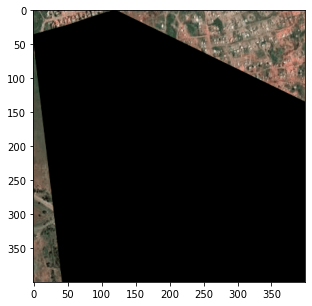

In [9]:
plot_fig(img_with_ward_cropped)

In [10]:
## All pixels that aren't black
pix_out_ward = np.where(np.all(img_with_ward_cropped != [0,0,0], axis=-1))

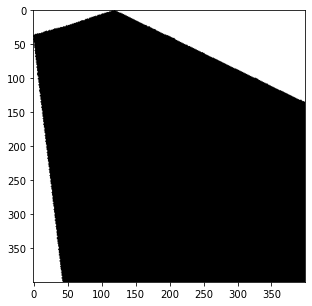

In [11]:
## Setting all non-black pixels to white
img_with_ward_cropped[pix_out_ward] = [255,255,255]
plot_fig(img_with_ward_cropped)

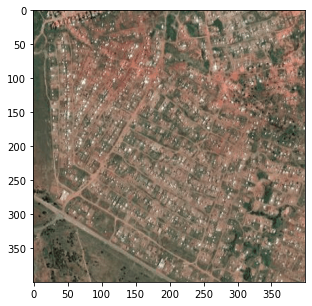

In [12]:
plot_fig(img_no_ward_cropped)

In [13]:
img_no_ward_cropped[pix_out_ward] = [0,0,0]       # setting all non-black pixels from other image to black in this image

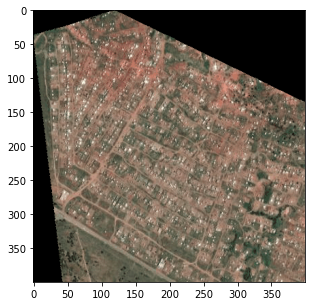

In [14]:
plot_fig(img_no_ward_cropped)

## Removing Google Watermarks (example)

In [24]:
# Using top-left image as example
delta_y = Y_RAD/16
center_str_shifted = str(-26.483020238999927 - delta_y) + ',27.828767997000057'
center_str_shifted

'-26.483260863999927,27.828767997000057'

In [25]:
# Need to load a larger image so that we can crop to 400x400
# Adding 12.5px to top and bottom of image. Then cropping bottom 25px (the watermark)
# To adjust for this, we need shift the center of the image down 12.5px
# request_no_ward = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str + "&zoom=16&size=400x425&maptype=satellite&format=png&key=" + KEY

request_shifted = "https://maps.googleapis.com/maps/api/staticmap?center=" + center_str_shifted + "&zoom=16&size=400x425&maptype=satellite&format=png&key=" + KEY
# HTTP requests
response_shifted = requests.get(request_shifted)
    
# storing the response in a file (image)

with open('../test_shifted.png', 'wb') as file:
   # writing data into the file
   file.write(response_shifted.content)

In [26]:
img_with_ward = cv2.imread("../test.png")
img_shifted = cv2.imread("../test_shifted.png")
img_no_ward = cv2.imread("../images/ward_1/00.png")
print(img_with_ward.shape)
print(img_shifted.shape)
print(img_no_ward.shape)

(425, 400, 3)
(425, 400, 3)
(400, 400, 3)


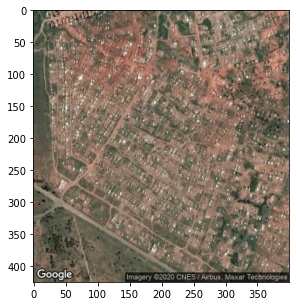

In [27]:
plot_fig(img_shifted)

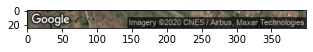

In [28]:
plot_fig(img_shifted[400:,:,:])

(400, 400, 3)


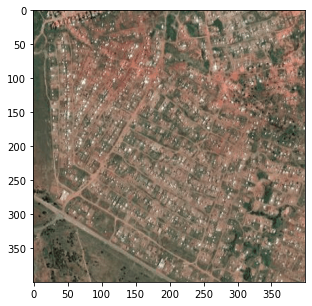

In [29]:
plot_fig(img_shifted[0:400,:,:])    # removing Google Watermarks
print(img_shifted[0:400,:,:].shape) # check the shape

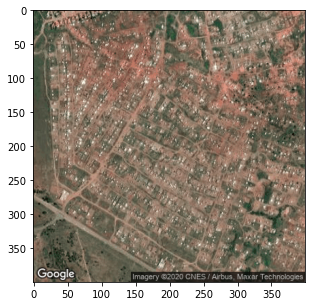

In [15]:
# check with current sample images for match
plot_fig(img_no_ward)